**Names:** Aden Pessin & Iva Morozova \
**Class:** Info 101\
**Assignment:** Data Exploration Project\
**Due:** Saturday Nov 9, 2024 11:59pm

For our project, we looked into housing data on Zillow.com. We wanted to plot a time series, to see if it will help us reach a conclusion to our questions:



1.   What are the **top 5 cities** with the most expensive single family homes in MA?
2. What are the **bottom 5 cities** with the least expensive single family homes in MA?
3.   Is there a relationship, over time, between the regions in Massachusetts with the lowest average price of single family homes, to the regions with the highest average price of single family homes?



We used the library ***scales***, as it helps with the scaling of the axis on the plot.

In [1]:
library (tidyverse)
install.packages("scales")
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




For our dataset, which we got from [Zillow.com](https://www.zillow.com/research/data/?msockid=34ee04c36b49692931d016c16a696881), we chose **"ZHVI Single-Family Homes Time Series ($)"**. This dataset is based off the *Zillow Home Value Index(ZHVI)*, which is a measure of the typical home value and market changes across the United States. The file contains these columns (Bolded is what we used):

*   **RegionName** (string)
*   **StateName** (string)
*   **State** (string)
*   RegionID (zip code) (int)
*   SizeRank (int)
*   RegionType (string)
*   Metro (string)
*   County Name (string)
*   **Date Columns**: yyyy-mm-dd (long)
*  * Range: January, 2000 --> September, 2024


 We chose to get the data at the city level, as we wanted to specifically focus on Massachusettes city regions.


 Zillow gathered this data from the data scraped from their own website. Last updated September 29, 2024

In [3]:
houseprice <- read_csv("projdata.csv") # Reading the raw file

Rows: 21515 Columns: 305
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): RegionName, RegionType, StateName, State, Metro, CountyName
dbl (299): RegionID, SizeRank, 2000-01-31, 2000-02-29, 2000-03-31, 2000-04-3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Filter the houseprice data frame to include only data for Massachusetts
# using either the 'State' or 'StateName' column (incase there are inconstancies)
df_ma <- houseprice %>% filter(State == 'MA'|StateName == 'MA')


# Calculate the average price for each row (house)
# by averaging the values in columns that start with "2" (price columns, all dates start with a 2)
# and store the result in a new column called "AvgPrice"
df_ma <- df_ma %>%
  mutate(AvgPrice = rowMeans(select(., starts_with("2")), na.rm = TRUE))

Now that we have just MA data, and have an average for each row, we can move on to sorting the city regions.

In [5]:
# Group by city and calculate the average price
city_avg <- df_ma %>%
  group_by(RegionName) %>%
  summarize(AvgPrice = mean(AvgPrice, na.rm = TRUE))

# Get the top 5 cities with the highest average prices
top_5_cities <- city_avg %>%
  arrange(desc(AvgPrice)) %>%
  slice_head(n = 5)

# Get the top 5 cities with the lowest average prices
bottom_5_cities <- city_avg %>%
  arrange((AvgPrice)) %>%
  slice_head(n = 5)

# For top 5 Regions:
cat("Top 5 Regions in MA with the highest average price of single family homes\n")
cat(paste(top_5_cities$RegionName, paste0("$", sprintf("%.2f", top_5_cities$AvgPrice)), sep = ": ", collapse = "\n"), "\n\n")

# For bottom 5 Regions:
cat("Bottom 5 Regions in MA with the lowest average price of single family homes\n")
cat(paste(bottom_5_cities$RegionName, paste0("$", sprintf("%.2f", bottom_5_cities$AvgPrice)), sep = ": ", collapse = "\n"), "\n")


Top 5 Regions in MA with the highest average price of single family homes
Chilmark: $1954727.39
Nantucket: $1502101.85
Weston: $1318297.59
Brookline: $1281585.09
Aquinnah: $1224822.20 

Bottom 5 Regions in MA with the lowest average price of single family homes
North Adams: $135209.44
Adams: $146161.63
Florida: $151180.21
Springfield: $153273.49
Athol: $163459.04 


After getting the top and bottom 5 city regions, we can use the average price column we created to plot a time series

`summarise()` has grouped output by 'RegionName'. You can override using the
`.groups` argument.


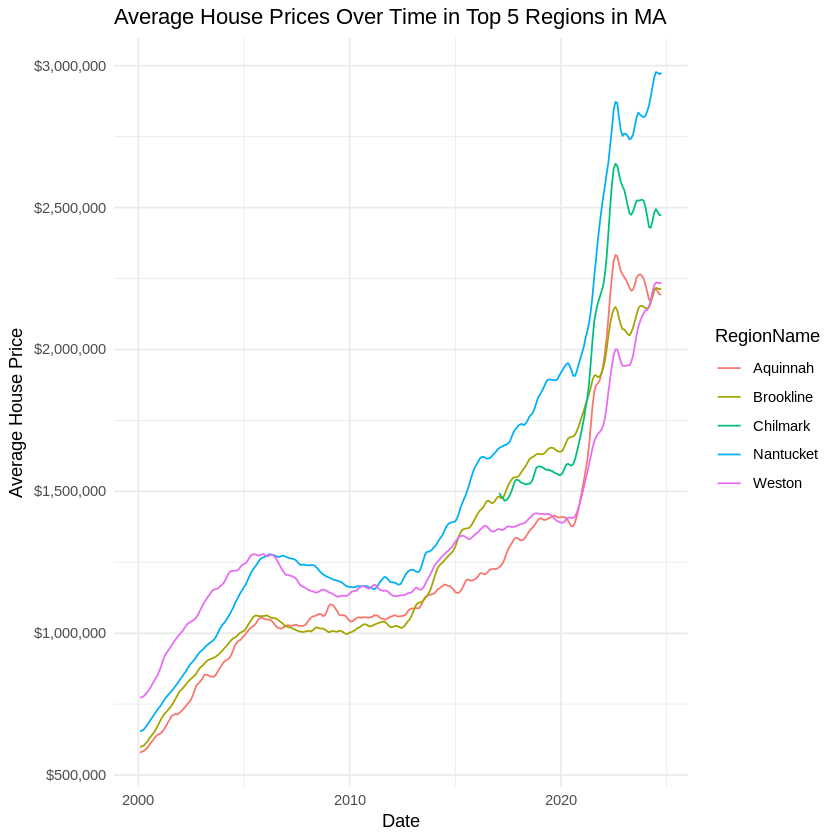

In [6]:
# Reshape the data from wide to long format
df_long <- df_ma %>%
  pivot_longer(cols = starts_with("2"), names_to = "Date", values_to = "Price") %>%
  mutate(Date = as.Date(Date, format = "%Y-%m-%d"))

# Calculate the average price for each city and date
city_date_avg <- df_long %>%
  filter(!is.na(Price)) %>%  # Filter out NAs
  group_by(RegionName, Date) %>%
  summarize(AvgPrice = mean(Price, na.rm = TRUE))

# Calculate the overall average price for each city
city_avg <- city_date_avg %>%
  group_by(RegionName) %>%
  summarize(OverallAvgPrice = mean(AvgPrice, na.rm = TRUE))

# Get the top 5 cities with the highest overall average prices
top_5_cities <- city_avg %>%
  arrange(desc(OverallAvgPrice)) %>%
  slice_head(n = 5) %>%
  pull(RegionName)

# Filter the data for the top 5 cities
city_date_avg_top5 <- city_date_avg %>%
  filter(RegionName %in% top_5_cities)

# Plot the time series using ggplot
ggplot(city_date_avg_top5, aes(x = Date, y = AvgPrice, color = RegionName)) +
  geom_line() +
  scale_y_continuous(breaks = pretty_breaks(n = 5), labels = dollar_format(prefix = "$")) +
  labs(title = "Average House Prices Over Time in Top 5 Regions in MA",
       x = "Date",
       y = "Average House Price") +
  theme_minimal()


Now, we do the same for the bottom 5 city regions.

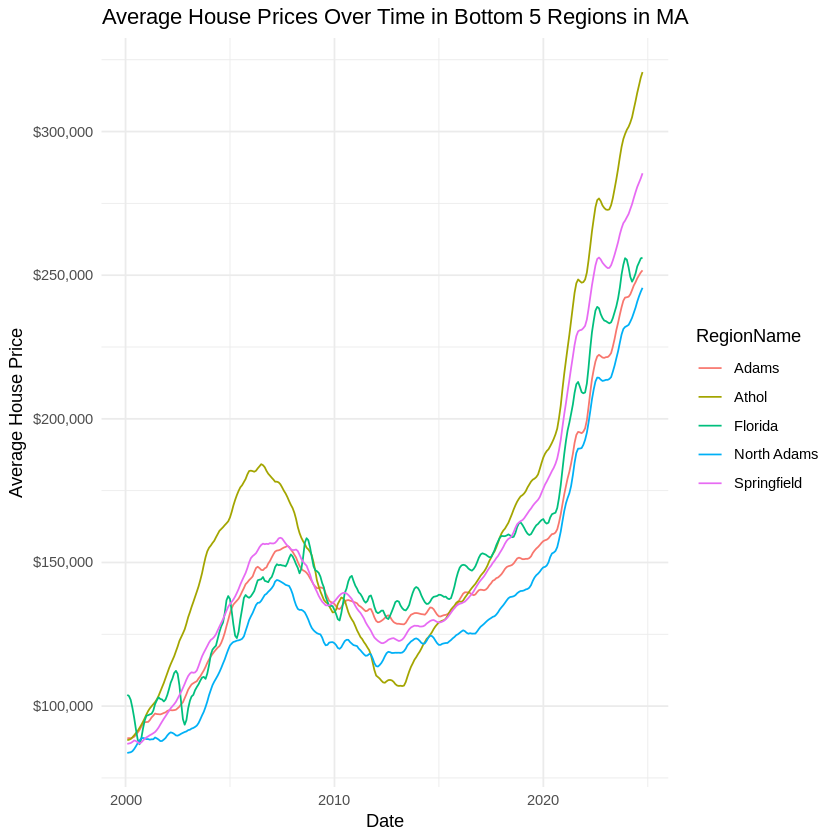

In [7]:
bottom_5_cities <- city_avg %>%
  arrange(OverallAvgPrice) %>%
  slice_head(n = 5) %>%
  pull(RegionName)
# Filter the data for the bottom 5 cities
city_date_avg_bottom5 <- city_date_avg %>%
  filter(RegionName %in% bottom_5_cities)

# Plot the time series
ggplot(city_date_avg_bottom5, aes(x = Date, y = AvgPrice, color = RegionName)) +
  geom_line() +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 5), labels = scales::dollar_format(prefix = "$")) +
  labs(title = "Average House Prices Over Time in Bottom 5 Regions in MA",
       x = "Date",
       y = "Average House Price") +
  theme_minimal()

For our project, we wanted to look at the top and bottom five cities in Massachusetts with the most and least expensive single family homes, respectively. We chose to utilize the housing data measured by Zillow using the Zillow Home Value Index (ZHVI). ZHVI collects information on the typical values of homes and properties in the 35th to 65th percentile (accounting for more than 100 million US homes) over the course of each month, starting from the last day when that respective month’s Market Reports are released.

By downloading the raw datafile with the data type “ZHVI Single-Family Homes Time Series ($)” and the “Geography” set to “City”, we were able to access the average home values of each city in the country from January 2000 to September 2024. Once obtained and loaded using read_csv() from the tidyverse package, we cleaned this data to first focus on specifically Massachusetts cities with the original goal in mind, using the filter() function to isolate the State and StateName rows with “MA” in them. Next, we calculated the average price for each row and created the AvgPrice column to find the average house price for each region, and then used group_by() and summarize() to sort the list by the name of the region and average price. From this, we found the top five cities with the highest prices and the bottom five cities with the lowest prices, and listed them out. We then decided to make the dataset have separate rows for each month and region, finding the average price for each city by month. With this information, we were able to create a time series to better understand and visualize the price trends of both the top five and bottom five cities.

Throughout this process, we noticed that the cities in this dataset were more likely to have the more expensive housing if they were more urban (closer to metropoles) or were closer to more amenities and attractions, and the less expensive homes were more likely to be located in rural areas of the state, further from the metropolis. We also noted, by looking at both of the time series, that the prices of the top and bottom cities followed the same trends throughout the twenty four year period, showing that they grew at similar rates and that trends are not dependent on the starting prices, but change based on state-wide economic trends. When it comes to limitations, because the dataset came from one source that conducts its own research into the housing market based on its own estimates (“Zestimates”), many specific numbers may end up being inaccurate. Despite this, it is still useful in seeing overall market trends and the relationship between different housing price ranges.
